In [38]:
import pandas as pd
import os
import sys
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
from tqdm import tqdm
import matplotlib.pyplot as plt

In [39]:
datadir = '/cellar/users/snwright/Data/RareCommon'
inputdir='/cellar/users/snwright/Data/RareCommon/inputs/UKB'

## Load matches

In [140]:
gb_ga = pd.read_csv(os.path.join(inputdir,'trait_matches_genebass_atlas_Mar25.txt' ), sep='\t')
gb_gc = pd.read_csv(os.path.join(inputdir, 'archive/trait_matches_genebass_gwascat_Mar12.txt' ), sep='\t')
ra_ga = pd.read_csv(os.path.join(inputdir, 'archive/trait_matches_ravar_atlas_Mar12.txt'), sep='\t')
ra_gc = pd.read_csv(os.path.join(inputdir, 'archive/trait_matches_ravar_gwascat_Mar12.txt'), sep='\t')

In [141]:
#gb_ga = gb_ga[gb_ga.Cosine>=0.8]
#gb_gc = gb_gc[gb_gc.Cosine>=0.8]

In [142]:
matches = {'RA_GA':ra_ga, 'RA_GC':ra_gc, 'GB_GA': gb_ga, 'GB_GC':gb_gc}

In [143]:
all_gc = set(gb_gc.StudyC.unique()).union(set(ra_gc.StudyC.unique()))
all_ga = set(gb_ga.StudyC.unique()).union(set(ra_ga.StudyC.unique()))
all_gb = set(gb_gc.StudyR.unique()).union(set(gb_ga.StudyR.unique()))
all_ra = set(ra_gc.StudyR.unique()).union(set(ra_ga.StudyR.unique()))

## Load info

In [144]:
info_files = {'RA_GA':{'R':'RAVAR/UKB_Atlas_matched_trait_info.txt',
 'C':'GWASAtlas/UKB_Atlas_RAVAR_matched_traits.tsv'},
'RA_GC':{'R':'RAVAR/UKB_GWAScat_matched_trait_info.txt',
 'C':'GWASCatalog/UKB_GWASCat_RAVAR_matched_traits.tsv'},
'GB_GA':{'R':'GeneBASS/UKB_Atlas_matched_trait_info2.txt',
 'C':'GWASAtlas/UKB_Atlas_Genebass_matched_traits2.tsv'},
'GB_GC':{'R':'GeneBASS/UKB_Genebass_GWASCat_matched_traits.tsv',
'C':'GWASCatalog/UKB_GWASCat_Genebass_matched_traits.tsv'},
}

In [146]:
for k, df in matches.items():
    rare_info = pd.read_csv(os.path.join(datadir, info_files[k]['R']), sep='\t')
    common_info = pd.read_csv(os.path.join(datadir, info_files[k]['C']), sep='\t')
    df['N_R'] = df.StudyR.map(rare_info.set_index('StudyR').N.to_dict())
    df['N_C'] = df.StudyC.map(common_info.set_index('StudyC').N.to_dict())
    df.dropna(subset=['N_R', 'N_C'], inplace=True)

## GeneBass and GWAS Atlas

### Common genesets

In [154]:
common_info = pd.read_csv(os.path.join(datadir, info_files['GB_GA']['C']), sep='\t')
common_info['StudyID'] =  [str(x+1) for x in common_info.ga_idx.values]

In [155]:
common_info.shape

(96, 27)

In [50]:
# extract the MAGMA results - rather than redoing the mapping? The do it later as back up if a reviewer asks
gda = pd.read_csv(os.path.join(datadir, 'GWASAtlas', 'gwasATLAS_v20191115_magma_P.txt.gz'), sep='\t')

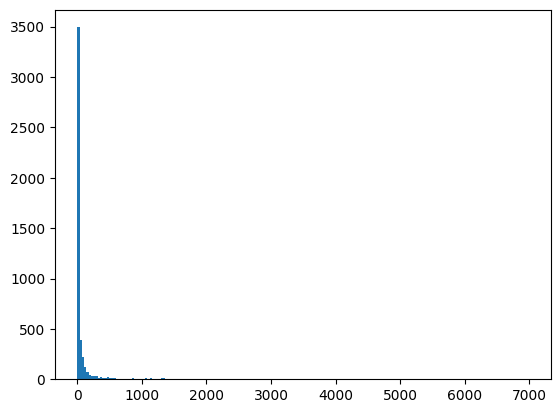

In [51]:
_ = plt.hist((gda.iloc[:, 1:] < 0.0001).sum(axis=0), bins=200)

In [52]:
# exclude any with > 1000 associations

In [56]:
a = (gda.iloc[:, 1:] < 0.0001).sum(axis=0)
exclude = a[a>1000].index.values

In [57]:
gda.head()

,GENE,1,2,3,4,5,6,7,8,9,...,4747,4748,4749,4750,4751,4752,4753,4754,4755,4756
0,ENSG00000187634,0.64021,0.84717,0.90468,0.013716,0.76987,0.43915,0.34780,0.066214,0.36546,...,0.35155,0.86936,0.085161,0.17078,0.67782,0.40413,0.44884,0.60446,0.51352,0.001329
1,ENSG00000268179,0.33239,NaN,NaN,0.023203,NaN,0.36447,0.35362,0.811300,0.32708,...,0.41873,0.88701,0.117120,0.15510,0.63112,0.49624,0.56169,0.50775,0.53597,0.008903
2,ENSG00000188976,0.72369,0.94607,0.95497,0.476390,0.38020,0.52761,0.44779,0.038721,0.56092,...,0.30863,0.50516,0.199810,0.27495,0.72896,0.13048,0.28646,0.62546,0.20731,0.237660
3,ENSG00000187961,0.66030,0.88834,0.95336,0.429610,0.66670,0.34194,0.60152,0.562100,0.99521,...,0.27700,0.19786,0.233080,0.23743,0.40377,0.11049,0.20040,0.47861,0.13320,0.337970
4,ENSG00000187583,0.83297,0.53952,0.12713,0.423970,0.03282,0.47569,0.63227,0.040060,0.55197,...,0.80322,0.22056,0.479760,0.84598,0.74295,0.67911,0.61874,0.83054,0.56658,0.209870


In [58]:
gda = gda.loc[:, ['GENE']+list(common_info['StudyID'].values)]

In [ ]:
ensembl_map, missing = qe.get_latest_ensembl_id(gda['GENE'].unique())

In [117]:
ensembl_to_entrez, missing_entrez = gm.convert_node_ids(ensembl_map['to'].values, 'Ensembl', 'Entrez')
ensembl_map['Entrez'] = [ensembl_to_entrez[x] if x in ensembl_to_entrez else '' for x in ensembl_map['to']]
id_ensembl = gda.merge(ensembl_map.loc[:, ('from', 'Entrez')], left_on='GENE', right_on='from', how='inner')
id_ensembl = id_ensembl[id_ensembl['Entrez'] != '']

In [119]:
id_ensembl['Entrez'].value_counts().head()

Entrez
1201      2
10492     2
54984     2
27229     1
117155    1
Name: count, dtype: int64

In [ ]:
id_ensembl.to_csv(os.path.join(datadir, 'GWASAtlas', 'gda_entrez_mapped.tsv'), sep='\t', index=True)

In [150]:
id_ensembl = pd.read_csv(os.path.join(datadir, 'GWASAtlas', 'gda_entrez_mapped.tsv'), sep='\t', index_col=0)

In [151]:
id_ensembl[id_ensembl['Entrez'].isin(['1201', '10492', '54984'])]
drop= ['ENSG00000271793', 'ENSG00000261832', 'ENSG00000258724']
id_ensembl = id_ensembl[~id_ensembl['GENE'].isin(drop)]

In [152]:
id_ensembl.columns

Index(['GENE', '1141', '1142', '1173', '3185', '3186', '3187', '3188', '3208',
       '3228',
       ...
       '4738', '4740', '4741', '4745', '4749', '4751', '4753', '4754', 'from',
       'Entrez'],
      dtype='object', length=169)

In [18]:
for i, idx in tqdm(enumerate(id_ensembl.columns[1:-2])):
    results = id_ensembl.loc[:, ('Entrez', 'GENE', idx)]
    results = results[results[idx] < 0.001]
    results.columns = ['Entrez', 'Ensembl ID', 'P-value']
    results['StudyID'] = idx
    outpref = common_info[common_info.StudyID==idx].StudyC.values[0]
    try:
        results.to_csv(os.path.join(inputdir, outpref + '_CV.txt'), sep='\t', index=False)
    except:
        outpref = ''.join(outpref.split(': https://doi.org/10.1101/'))
        results.to_csv(os.path.join(inputdir, outpref + '_CV.txt'), sep='\t', index=False)

166it [00:01, 117.10it/s]


In [19]:
for i, idx in tqdm(enumerate(id_ensembl.columns[1:-2])):
    results = id_ensembl.loc[:, ('Entrez', 'GENE', idx)]
    results = results[results[idx] < 2.5e-6]
    results.columns = ['Entrez', 'Ensembl ID', 'P-value']
    results['StudyID'] = idx
    outpref = common_info[common_info.StudyID==idx].StudyC.values[0]
    try:
        results.to_csv(os.path.join(inputdir, outpref + '_256_CV.txt'), sep='\t', index=False)
    except:
        outpref = ''.join(outpref.split(': https://doi.org/10.1101/'))
        results.to_csv(os.path.join(inputdir, outpref + '_256_CV.txt'), sep='\t', index=False)

166it [00:00, 193.10it/s]


In [20]:
common_studies = gb_ga.StudyC.values
common_studies  = [''.join(outpref.split(': https://doi.org/10.1101/')) if 'BioRxiv' in outpref else outpref for outpref in common_studies ]

In [21]:
common_studies

['GA_idx4174_UKB2_30048462',
 'GA_idx3238_UKB2_31427789',
 'GA_idx4293_UKB2_30696823',
 'GA_idx1140_UKB1_27494321',
 'GA_idx1141_UKB1_27494321',
 'GA_idx4271_UKB2_30846698',
 'GA_idx3227_UKB2_31427789',
 'GA_idx3792_UKB2_30804565',
 'GA_idx4174_UKB2_30048462',
 'GA_idx4252_UKB2_30952852',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4709_UKB2_BioRxiv288618',
 'GA_idx4709_UKB2_BioRxiv288618',
 'GA_idx3989_UKB2_29500382',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4174_UKB2_30048462',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4709_UKB2_BioRxiv288618',
 'GA_idx4327_UKB2_30598549',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4679_UKB2_BioRxiv288588',
 'GA_idx4709_UKB2_BioRxiv288618',
 'GA_idx3346_UKB2_31427789',
 'GA_idx4708_UKB2_BioRxiv288617',
 'GA_idx4679_UKB

In [22]:
with open(os.path.join(inputdir, 'gb_ga_common.traitlist'), 'w') as f:
    f.writelines('\n'.join(common_studies)+'\n')
    
with open(os.path.join(inputdir, 'gb_ga_common_256.traitlist'), 'w') as f:
    f.writelines('\n'.join([x+'_256' for x in common_studies])+'\n')

In [23]:
rare_studies= gb_ga.StudyR.values
with open(os.path.join(inputdir, 'gb_ga_rare.traitlist'), 'w') as f:
    f.write('\n'.join(rare_studies)+'\n')
with open(os.path.join(inputdir, 'gb_ga_rare_256.traitlist'), 'w') as f:
    f.write('\n'.join([x+'_256' for x in rare_studies])+'\n')

numbers don't match because I did some extra filtering. 

### Rare genesets

In [123]:
rare_info = pd.read_csv(os.path.join(datadir, info_files['GB_GA']['R']), sep='\t', index_col=0)
rare_info.head(1)

,n_cases,n_controls,heritability,saige_version,inv_normalized,trait_type,phenocode,pheno_sex,coding,modifier,...,n_cases_both_sexes,n_cases_females,n_cases_males,description,description_more,coding_description,category,N,gb_idx,StudyR
375,229,394554.0,0.0,SAIGE_0.44.5,False,categorical,20003,both_sexes,1.140872e+09,NaN,...,289,142,130,treatment/medication code,Code for treatment Negative codes indicate fre...,morphine,UK Biobank Assessment Centre > Verbal intervie...,394783.0,375,GB_UKB_idx375_phe20003


In [124]:
rare_gda = pd.read_csv('/cellar/users/snwright/Data/Transfer/RVC/data/Genebass_filtered_significant_study_results.tsv.gz', sep='\t')

In [134]:
rare_gda.nunique()

gene_id           18044
gene_symbol       18043
annotation            4
trait_type            2
phenocode           519
pheno_sex             3
coding               33
modifier              2
Pvalue           349782
Pvalue_Burden    324363
Pvalue_SKAT      341661
BETA_Burden      750696
dtype: int64

In [126]:
all_genes = rare_gda.loc[:, ('gene_id', 'gene_symbol')].drop_duplicates()

In [127]:
genebass_ensembl = rare_gda.gene_id.unique()
genenass_symbol = rare_gda.gene_symbol.unique()

In [128]:
ensembl_map, missing = qe.get_latest_ensembl_id(genebass_ensembl)
ensembl_to_entrez, missing_entrez = gm.convert_node_ids(ensembl_map['to'].values, 'Ensembl', 'Entrez')
ensembl_map['Entrez'] = [ensembl_to_entrez[x] if x in ensembl_to_entrez else '' for x in ensembl_map['to']]

Query batch 0 - 1000
Query batch 1000 - 2000
Query batch 2000 - 3000
Query batch 3000 - 4000
Query batch 4000 - 5000
Query batch 5000 - 6000
Query batch 6000 - 7000
Query batch 7000 - 8000
Query batch 8000 - 9000
Query batch 9000 - 10000
Query batch 10000 - 11000
Query batch 11000 - 12000
Query batch 12000 - 13000
Query batch 13000 - 14000
Query batch 14000 - 15000
Query batch 15000 - 16000
Query batch 16000 - 17000
Query batch 17000 - 18000
Query batch 18000 - 18044


In [129]:
all_genes = all_genes.merge(ensembl_map, left_on='gene_id', right_on='from')

In [130]:
missing = all_genes[all_genes.Entrez=='']

In [131]:
symbol_map, symbol_missing = qh.perform_hgnc_query(missing.gene_symbol.unique(), 'Symbol', 'Symbol')
symbol_to_entrez, missing2 = gm.convert_node_ids(list(symbol_map.values()), 'Symbol', 'Entrez')
symbol_map = pd.DataFrame(symbol_map.items(), columns=['from', 'to'])
symbol_map['Entrez'] = [symbol_to_entrez[x] if x in symbol_to_entrez else '' for x in symbol_map['to']]

Initial Ids 458
Checking approved symbols
Response received
Check names 398
Previous Ids 394
Checking previous symbols
Alias Ids 382
Searching aliases


In [135]:
symbol_mapped = missing.drop(columns=['Entrez', 'from']).merge(symbol_map, left_on='gene_symbol', right_on='from')

In [133]:
all_genes.head()

,gene_id,gene_symbol,from,to,Entrez
0,ENSG00000000003,TSPAN6,ENSG00000000003,ENSG00000000003,7105
1,ENSG00000000005,TNMD,ENSG00000000005,ENSG00000000005,64102
2,ENSG00000000419,DPM1,ENSG00000000419,ENSG00000000419,8813
3,ENSG00000000457,SCYL3,ENSG00000000457,ENSG00000000457,57147
4,ENSG00000000460,C1orf112,ENSG00000000460,ENSG00000000460,55732


In [136]:
all_mapped = pd.concat([symbol_mapped.drop(columns=['to_x', 'to_y']), all_genes[all_genes.Entrez!= ''].drop(columns=['to'])])

In [137]:
rare_gda = rare_gda.merge(all_mapped.loc[:, ('gene_id', 'gene_symbol', 'Entrez')], on=['gene_id', 'gene_symbol'], how='inner')

In [138]:
rare_gda.to_csv(os.path.join(datadir, 'GeneBASS', 'UKB_mapped_gene_results.tsv'), sep='\t', index=False)

In [139]:
rare_gda = pd.read_csv(os.path.join(datadir, 'GeneBASS', 'UKB_mapped_gene_results.tsv'), sep='\t')

In [36]:
rare_gda_sig = rare_gda[rare_gda.Pvalue<0.001]

In [37]:
rare_gda_sig.h

,gene_id,gene_symbol,annotation,trait_type,phenocode,pheno_sex,coding,modifier,Pvalue,Pvalue_Burden,Pvalue_SKAT,BETA_Burden
156,ENSG00000000003,TSPAN6,missense|LC,continuous,25144,both_sexes,NaN,irnt,0.000362,0.003328,0.000271,0.013633
160,ENSG00000000003,TSPAN6,missense|LC,continuous,25148,both_sexes,NaN,irnt,0.000368,0.021356,0.000275,0.010755
197,ENSG00000000003,TSPAN6,missense|LC,continuous,25240,both_sexes,NaN,irnt,0.000027,0.002405,0.000021,0.014191
198,ENSG00000000003,TSPAN6,missense|LC,continuous,25241,both_sexes,NaN,irnt,0.000390,0.004561,0.000286,0.013383
201,ENSG00000000003,TSPAN6,missense|LC,continuous,25244,both_sexes,NaN,irnt,0.000778,0.027852,0.000565,0.010304


In [190]:
### create the gene sets

In [44]:
rare_info = rare_info.fillna(np.nan)

In [45]:
for i, studyR in tqdm(enumerate(rare_info.StudyR.values)):
    phenocode=rare_info.iloc[i].phenocode
    coding = rare_info.iloc[i].coding
    trait_type=rare_info.iloc[i].trait_type
    modifier = rare_info.iloc[i].modifier
    results = rare_gda_sig[(rare_gda_sig.phenocode==phenocode) & (rare_gda_sig.trait_type==trait_type)]
    if coding > 0:
        results = results[results.coding==coding]
    if isinstance(modifier, str):
        results = results[results.modifier==modifier]
    # Take the most significant model    
    results = results.sort_values('Pvalue', ascending=True).drop_duplicates(subset=['Entrez'])
    results_out = results.loc[:, ('gene_id', 'gene_symbol', 'Pvalue', 'BETA_Burden', 'Entrez')]
    results_out.columns = ['Ensembl ID', 'Gene Symbol', 'P-value', 'BETA_Burden', 'Entrez']
    results_out.to_csv(os.path.join(inputdir, studyR + '_RV.txt'), sep='\t', index=False)

500it [00:18, 26.79it/s]


In [46]:
rare_gda_sig2 = rare_gda[rare_gda.Pvalue<2.5e-6]

In [47]:
for i, studyR in tqdm(enumerate(rare_info.StudyR.values)):
    phenocode=rare_info.iloc[i].phenocode
    coding = rare_info.iloc[i].coding
    trait_type=rare_info.iloc[i].trait_type
    modifier = rare_info.iloc[i].modifier
    results = rare_gda_sig2[(rare_gda_sig2.phenocode==phenocode) & (rare_gda_sig2.trait_type==trait_type)]
    if coding > 0:
        results = results[results.coding==coding]
    if isinstance(modifier, str):
        results = results[results.modifier==modifier]
    # Take the most significant model    
    results = results.sort_values('Pvalue', ascending=True).drop_duplicates(subset=['Entrez'])
    results_out = results.loc[:, ('gene_id', 'gene_symbol', 'Pvalue', 'BETA_Burden', 'Entrez')]
    results_out.columns = ['Ensembl ID', 'Gene Symbol', 'P-value', 'BETA_Burden', 'Entrez']
    results_out.to_csv(os.path.join(inputdir, studyR + '_256_RV.txt'), sep='\t', index=False)

500it [00:04, 114.93it/s]


## RAVAR + GWASCatalog

Because I already have these

In [49]:
rare_info = pd.read_csv(os.path.join(datadir, info_files['RA_GC']['R']), sep='\t')
rare_info.head()

,Reported Trait,Trait Label,Trait Ontology id,EFO synonym,PMID,TRAIT_CODE,geneCount,ravar_idx,StudyR,N
0,Biochemistry Gamma Glutamyl transferase measur...,serum gamma-glutamyl transferase measurement,EFO:0004532,GGT measurement;Gamma gluatamyl transferase le...,34226706.0,EFO_0004532,33,4,UKB_RAVAR_idx34226706.0_EFO_0004532,437651.0
1,Biochemistry Total Bilirubin measurement,bilirubin measurement,EFO:0004570,bilirubin levels,34226706.0,EFO_0004570,23,6,UKB_RAVAR_idx34226706.0_EFO_0004570,436055.0
2,Biochemistry Triglycerides,triglyceride,CHEBI:17855,triglycerides;Triglyceride,34226706.0,CHEBI_17855,25,7,UKB_RAVAR_idx34226706.0_CHEBI_17855,437532.0
3,Biochemistry Apolipoprotein B measurement,apolipoprotein B change measurement,EFO:0020874,NaN,34226706.0,EFO_0020874,28,8,UKB_RAVAR_idx34226706.0_EFO_0020874,435744.0
4,Lipoprotein_a,lipoprotein,EFO:0003836,"Circulating Lipoproteins;Lipoproteins, Circula...",37262146.0,EFO_0003836,14,16,UKB_RAVAR_idx37262146.0_EFO_0003836,322389.0


In [ ]:
ravar_genes = pd.read_csv(os.path.join(datadir, '/RAVAR' ,'gene_fulltable_06112024.txt.entrez'),sep='\t', 
                            usecols=['Gene Symbol', 'Ensembl ID', 'Gene Type', 'Entrez', 'CHR', 'Location', 'Reported Trait', 'Trait Label', 'Trait Ontology id', 'EFO synonym', 'P-value', 'PMID'])
#replace '−' with '-'
ravar_genes['P-value'] = ravar_genes['P-value'].apply(lambda x: float(x.replace('−','-')) if type(x) == str else float(x))
ravar_genes['TRAIT_CODE'] = ravar_genes['Trait Ontology id'].apply(lambda x: x.replace(":", "_") if type(x) == str else x)
ravar_genes['logp'] = -1 * np.log10(ravar_genes['P-value'] + 1e-250)
ravar

In [51]:
df_rare

,cat_idx,DISEASE/TRAIT,ravar_idx,Reported Trait,Cosine,StudyR,StudyC,N_R,N_C
0,9491,angina,1211,Angina,1.000000,UKB_RAVAR_idx34375979.0_EFO_0003913,GC_idx9491_GCST90446533,281104.0,459138
1,106787,hernia,603,Hernia,1.000000,UKB_RAVAR_idx34375979.0_HP_0100790,GC_idx106787_GCST90245895,281104.0,344508
2,33656,mean reticulocyte volume,1497,Mean reticulocyte volume,1.000000,UKB_RAVAR_idx34375979.0_EFO_0010701,GC_idx33656_GCST90002396,281104.0,408112
3,29325,mean reticulocyte volume,1497,Mean reticulocyte volume,1.000000,UKB_RAVAR_idx34375979.0_EFO_0010701,GC_idx29325_GCST90025975,281104.0,436944
4,35295,triglycerides,20,Triglycerides,1.000000,UKB_RAVAR_idx36809768.0_CHEBI_17855,GC_idx35295_GCST90020235,97066.0,429011
...,...,...,...,...,...,...,...,...,...
4632,9597,free cholesterol levels in very small vldl,178,Cholesterol to Total Lipids in Small VLDL perc...,0.800094,UKB_RAVAR_idx36809768.0_EFO_0020945,GC_idx9597_GCST90093032,97924.0,115082
4633,114916,triglycerides to total lipids in very large vl...,899,Total Triglycerides to Total Lipids percentage,0.800094,UKB_RAVAR_idx36809768.0_EFO_0020947,GC_idx114916_GCST90269685,96285.0,87620
4634,115206,phospholipids to total lipids in medium ldl pe...,134,Phospholipids to Total Lipids in HDL percentage,0.800092,UKB_RAVAR_idx36809768.0_EFO_0020946,GC_idx115206_GCST90269716,98477.0,88329
4635,9794,phospholipid levels in small vldl,208,Phospholipids to Total Lipids in VLDL percentage,0.800090,UKB_RAVAR_idx36809768.0_EFO_0020946,GC_idx9794_GCST90092976,98477.0,115082


In [89]:
df_rare = ra_gc
df_rare = df_rare.merge(rare_info.loc[:, ('ravar_idx', 'StudyR', 'PMID', 'Trait Label', 'Trait Ontology id', 'geneCount')], on=['ravar_idx', 'StudyR'])
df_rare['comb_idx'] = df_rare['cat_idx'].astype(str) + '_' + df_rare['ravar_idx'].astype(str)

In [58]:
## Prioritize based on common

In [90]:
df_select_common = df_rare.sort_values(by=['N_R', 'Cosine'], ascending=False).drop_duplicates(subset='DISEASE/TRAIT')

In [91]:
df_select_rare = df_rare.sort_values(by=['N_C', 'Cosine'], ascending=False).drop_duplicates(subset='Reported Trait')

In [92]:
c_comb = set(df_select_common.comb_idx)
r_comb = set(df_select_rare.comb_idx)
print(len(c_comb.union(r_comb)))
print(len(c_comb.intersection(r_comb)))

714
129


In [93]:
final_pairs = pd.concat([df_select_common, df_select_rare]).drop_duplicates(subset=['comb_idx'])

In [72]:
[x for x in df_rare['Reported Trait'].values if x not in df_select_common['Reported Trait'].values]

['Mean reticulocyte volume',
 'Mean reticulocyte volume',
 'Platelet distribution width',
 'Platelet distribution width',
 'Mean corpuscular volume',
 'Mean corpuscular volume',
 'Mean corpuscular volume',
 'Platelet distribution width',
 'Height',
 'Mean corpuscular volume',
 'Height',
 'Mean corpuscular volume',
 'Platelet distribution width',
 'High light scatter reticulocyte count',
 'Lymphocyte count',
 'Mean corpuscular volume',
 'Lymphocyte count',
 'Reticulocyte count',
 'Mean corpuscular volume',
 'Lymphocyte count',
 'Lymphocyte count',
 'Reticulocyte count',
 'High light scatter reticulocyte count',
 'Lymphocyte count',
 'Lymphocyte count',
 'Mean corpuscular volume',
 'Monocyte count',
 'Monocyte count',
 'Monocyte count',
 'Monocyte count',
 'Monocyte count',
 'Monocyte count',
 'Monocyte count',
 'Monocyte count',
 'Cholesteryl Esters to Total Lipids in Medium LDL percentage',
 'Cholesteryl Esters to Total Lipids in Medium LDL percentage',
 'Cholesteryl Esters to Total Li

### Export the common gene sets

### Export the rare gene sets

In [94]:
final_pairs

,cat_idx,DISEASE/TRAIT,ravar_idx,Reported Trait,Cosine,StudyR,StudyC,N_R,N_C,PMID,Trait Label,Trait Ontology id,geneCount,comb_idx
39,33663,red blood cell count,1429,Red blood cell count,1.000000,UKB_RAVAR_idx33257650.0_EFO_0004305,GC_idx33663_GCST90002403,487409.0,408112,33257650.0,erythrocyte count,EFO:0004305,11,33663_1429
40,33662,platelet count,1967,Platelet count,1.000000,UKB_RAVAR_idx33257650.0_EFO_0004309,GC_idx33662_GCST90002402,487409.0,408112,33257650.0,platelet count,EFO:0004309,6,33662_1967
81,33641,eosinophil counts,398,Eosinophil count,0.986836,UKB_RAVAR_idx33257650.0_EFO_0004842,GC_idx33641_GCST90002381,487409.0,408112,33257650.0,eosinophil count,EFO:0004842,33,33641_398
1056,28704,mean platelet volume,1665,Mean platelet thrombocyte volume,0.896768,UKB_RAVAR_idx33257650.0_EFO_0004584,GC_idx28704_GCST90025960,487409.0,445364,33257650.0,mean platelet volume,EFO:0004584,11,28704_1665
1184,33650,mean corpuscular hemoglobin,1428,Mean corpuscular haemogliobin,0.892090,UKB_RAVAR_idx33257650.0_EFO_0004527,GC_idx33650_GCST90002390,487409.0,408112,33257650.0,mean corpuscular hemoglobin,EFO:0004527,15,33650_1428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,35535,glaucoma,1180,Glaucoma| unspecified,0.869106,UKB_RAVAR_idx34375979.0_MONDO_0005041,GC_idx35535_GCST90134547,281104.0,68390,34375979.0,glaucoma,MONDO:0005041,22,35535_1180
704,115743,hemoglobin concentration,479,Haemoglobin concentration,0.914386,UKB_RAVAR_idx34375979.0_EFO_0004528,GC_idx115743_GCST90258653,281104.0,52141,34375979.0,mean corpuscular hemoglobin concentration,EFO:0004528,10,115743_479
4004,115743,hemoglobin concentration,261,Blood HEMOGLOBIN measurement,0.817586,UKB_RAVAR_idx34226706.0_EFO_0004509,GC_idx115743_GCST90258653,445373.0,52141,34226706.0,hemoglobin measurement,EFO:0004509,22,115743_261
2414,106783,umbilical hernia,1051,Umbilical hernia without obstruction or gangrene,0.851983,UKB_RAVAR_idx34375979.0_HP_0001537,GC_idx106783_GCST90245891,281104.0,32136,34375979.0,Umbilical hernia,HP:0001537,19,106783_1051


In [57]:
df_rare[df_rare.geneCount < 5]

,cat_idx,DISEASE/TRAIT,ravar_idx,Reported Trait,Cosine,StudyR,StudyC,N_R,N_C,PMID,Trait Label,Trait Ontology id,geneCount
6,35295,triglycerides,904,Triglycerides,1.000000,UKB_RAVAR_idx31992710.0_CHEBI_17855,GC_idx35295_GCST90020235,46875.0,429011,31992710.0,triglyceride,CHEBI:17855,3
27,28707,mean corpuscular volume,1988,Mean corpuscular volume,1.000000,UKB_RAVAR_idx31992710.0_EFO_0004526,GC_idx28707_GCST90025963,50100.0,444035,31992710.0,mean corpuscular volume,EFO:0004526,3
32,33652,mean corpuscular volume,1988,Mean corpuscular volume,1.000000,UKB_RAVAR_idx31992710.0_EFO_0004526,GC_idx33652_GCST90002392,50100.0,408112,31992710.0,mean corpuscular volume,EFO:0004526,3
36,8271,mean corpuscular volume,1988,Mean corpuscular volume,1.000000,UKB_RAVAR_idx31992710.0_EFO_0004526,GC_idx8271_GCST90002337,50100.0,8188,31992710.0,mean corpuscular volume,EFO:0004526,3
53,34789,mean corpuscular volume,1988,Mean corpuscular volume,1.000000,UKB_RAVAR_idx31992710.0_EFO_0004526,GC_idx34789_GCST90056174,50100.0,362595,31992710.0,mean corpuscular volume,EFO:0004526,3
72,35537,myopia,1880,Myopia,1.000000,UKB_RAVAR_idx34375979.0_HP_0000545,GC_idx35537_GCST90134549,281104.0,64268,34375979.0,Myopia,HP:0000545,3
75,34087,asthma,2017,Asthma,1.000000,UKB_RAVAR_idx36138231.0_MONDO_0004979,GC_idx34087_GCST90014325,164470.0,408422,36138231.0,asthma,MONDO:0004979,4
289,8259,mean corpuscular hemoglobin,1987,Mean corpuscular haemoglobin,0.946638,UKB_RAVAR_idx31992710.0_EFO_0004527,GC_idx8259_GCST90002325,50101.0,8181,31992710.0,mean corpuscular hemoglobin,EFO:0004527,3
290,33650,mean corpuscular hemoglobin,1987,Mean corpuscular haemoglobin,0.946638,UKB_RAVAR_idx31992710.0_EFO_0004527,GC_idx33650_GCST90002390,50101.0,408112,31992710.0,mean corpuscular hemoglobin,EFO:0004527,3
886,33657,mean spheric corpuscular volume,1988,Mean corpuscular volume,0.905173,UKB_RAVAR_idx31992710.0_EFO_0004526,GC_idx33657_GCST90002397,50100.0,408112,31992710.0,mean corpuscular volume,EFO:0004526,3
